In [2]:
# looks for empty row based on values appearing in 1st N columns
def next_available_row(sheet, cols_to_sample=2):
    try:
        cols = sheet.range(1, 1, sheet.row_count, cols_to_sample)
        return max([cell.row for cell in cols if cell.value]) + 1
    except:
        return 1

def upload_to_sheets():
    #Run this code every night to scrape data, leave it running for the whole day
    #Pandas, Json and formatting stuff
    import pandas as pd
    import requests
    import json
    from datetime import datetime

    #GSheets Stuff
    import gspread
    from df2gspread import df2gspread as d2g
    from df2gspread import gspread2df as g2d
    from oauth2client.service_account import ServiceAccountCredentials
    from googleapiclient import discovery

    #For Sleep
    import time

    #Credential stuff
    scope = ["https://spreadsheets.google.com/feeds",
            "https://www.googleapis.com/auth/drive"]
    credentials = ServiceAccountCredentials.from_json_keyfile_name("./creds.json", scope)
    gc = gspread.authorize(credentials)

    #Set start and end time here
    start_hour = "06"
    end_hour = "00"

    #Start automatically at start_hour (please run the code before sleep every night)
    while (datetime.now().strftime("%H") != start_hour):
        print(datetime.now().strftime("%H:%M:%S"),end="\r")
        time.sleep(1)
    
    #Name new google sheets with in this format: <today's date>_carpark_availability
    wks_name = 'Sheet1'
    newsheet_name = "{}/{}/{}_carpark_availability".format(int(datetime.now().strftime("%d")), int(datetime.now().strftime("%m")), int(datetime.now().strftime("%Y")))
    destFolderId = "15ZD6Jp7ZeWJLOSm2CxmMzSjJ6fqtLfR_"
    drive_service = discovery.build('drive', 'v3', credentials=credentials)

    #Check if a sheet is already created for the day
    file_list = drive_service.files().list(q="name contains '{}'".format(newsheet_name),
                                           spaces='drive',
                                           fields='nextPageToken, files(id, name)',
                                           pageToken=None).execute()
    file_list = file_list.get("files", [])
    
    #to delete a file (debug purpose)
    #for file in file_list:
    #    drive_service.files().delete(fileId=file['id']).execute()
        
    #Create sheet
    if (file_list == []):
        body = {'name': newsheet_name,
                'mimeType': 'application/vnd.google-apps.spreadsheet',
                'parents': [destFolderId]}
        newsheet = drive_service.files().create(body=body).execute()
        spreadsheet_key = newsheet['id']
        new_sheet = gc.open_by_key(spreadsheet_key).worksheet(wks_name)
        new_sheet.delete_columns(1,18)
        
        #Update sheet's link to the google sheet that stores all spreadsheet keys
        spreadsheet_key_sheet = gc.open_by_key("1bms8J3Hiv_F3Mycsr14gwVZiJi1-ngLj0fNhdRkIAwQ").worksheet(wks_name)
        row = next_available_row(spreadsheet_key_sheet,1)
        spreadsheet_key_sheet.update("A{}".format(row), "{}/{}".format(datetime.now().strftime("%d"), datetime.now().strftime("%m")))
        spreadsheet_key_sheet.update("B{}".format(row), spreadsheet_key)
        spreadsheet_key_sheet.update("F{}".format(row), "https://docs.google.com/spreadsheets/d/{}/edit#gid=0".format(spreadsheet_key))
    else:
        spreadsheet_key = file_list[0]['id']
    
    #old code
    #df = g2d.download(key_to_spreadsheet_key, wks_name, col_names=False, row_names=False, credentials=credentials, start_cell='A1')
    #spreadsheet_key = list(df[1][df[0] == datetime.now().strftime("%d/%m")])[0]
    
    print("This script will grab data from LTA and upload it to "
          "https://docs.google.com/spreadsheets/d/"+spreadsheet_key+"/edit#gid=0 every 10 min. ")
    print("Press Ctrl + C to stop.\n")

    #LTA API URL (Total data per set = 2338)
    url_list = []
    headers = {'AccountKey': 'opoOfz6bTza7BMCTCy8VFA=='}
    for skip in range(0,2500,500):
        url_list.append('http://datamall2.mytransport.sg/ltaodataservice/CarParkAvailabilityv2?$skip='+str(skip))

    #End automatically at end_hour
    while (datetime.now().strftime("%H") != end_hour):
        df = pd.DataFrame(columns=['CarParkID','Area','Development','Location','AvailableLots','LotType','Agency'])
        for url in url_list:
            response = requests.get(url, headers=headers)
            carpark_info = json.loads(response.text)
            df = df.append(pd.DataFrame(carpark_info['value']), ignore_index=True)

        #df = pd.DataFrame(df[["CarParkID","AvailableLots"]])

        #Insert date and time into dataframe
        now = datetime.now()
        d_string = now.strftime("%d/%m/%Y")
        df.insert(0,'Date',d_string)
        t_string = now.strftime("%H:%M:%S")
        df.insert(0,'Time',t_string)
        print("Extracted data for "+d_string+" "+t_string)
        
        #Upload to sheets
        row = next_available_row(gc.open_by_key(spreadsheet_key).worksheet(wks_name),1)
        d2g.upload(df, spreadsheet_key, wks_name, col_names=False, row_names=False, clean=False, credentials=credentials, start_cell='A{}'.format(row))
        print("Upload succeeded. Sleeping for 10 min.")
        
        #Sleep for 10 minutes
        for i in range(1,600):
            print(str(int(i/60))+" minutes "+str(i%60)+" seconds elapsed",end="\r")
            time.sleep(1)

        print("\n")

In [3]:
#download data stored in google sheets to local device.
#all spreadsheet keys stored at https://docs.google.com/spreadsheets/d/1bms8J3Hiv_F3Mycsr14gwVZiJi1-ngLj0fNhdRkIAwQ/edit#gid=0
#downloaded data has header
def download_from_google_sheets():
    # Credential stuff
    scope = ["https://spreadsheets.google.com/feeds",
            "https://www.googleapis.com/auth/drive"]
    credentials = ServiceAccountCredentials.from_json_keyfile_name("./creds.json", scope)
    gc = gspread.authorize(credentials)

    ID_of_spreadsheet_keys = "1bms8J3Hiv_F3Mycsr14gwVZiJi1-ngLj0fNhdRkIAwQ"
    ID_of_one_set_data = "1J6c50eUbTeOLbMQ88dTpB5lV_fEg2l9Ke2rdhVGW9Mw"
    worksheet_name = 'Sheet1'

    #open sheet that stores all spreadsheet keys
    sheet = gc.open_by_key(ID_of_spreadsheet_keys)
    worksheet = sheet.worksheet(worksheet_name)
    spreadsheet_keys = {}
    dates_raw = worksheet.col_values(1)
    IDs = worksheet.col_values(2)
    for i in range(len(IDs)):
        spreadsheet_keys[(int(dates_raw[i].split("/")[0]), int(dates_raw[i].split("/")[1]))] = IDs[i]

    #check existing data in ./Data/
    existing_data = os.listdir("./Data/")
    existing_dates = [(int(i.split("_")[0]), int(i.split("_")[1])) for i in existing_data]
    for date in spreadsheet_keys.keys():
        if date not in existing_dates:
            #open sheet, select worksheet
            sheet = gc.open_by_key(spreadsheet_keys[date])
            worksheet = sheet.worksheet(worksheet_name)

            #download values into a dataframe
            df = pd.DataFrame(worksheet.get_all_values())

            #for data before 26/3/2021: only have 4 columns.
            #assume that "C" lotType carpark always have more available slots than other types of carpark. Remove duplicated data with same carpark ID.
            if (len(df.columns) == 4):
                df.columns = ["Time", "Date", "CarParkID","AvailableLots"]
                df = df.sort_values(by=["CarParkID", "AvailableLots"])
                df = df.drop_duplicates(subset=["CarParkID", "Time"], keep="last")
                
                #open sheet that stores one set of data (without time, date and availableLots)
                sheet = gc.open_by_key(ID_of_one_set_data)
                worksheet = sheet.worksheet(worksheet_name)
                one_set_data = pd.DataFrame(worksheet.get_all_values())
                one_set_data.columns = ["CarParkID","Area","Development", "Location", "LotType", "Agency"]
                one_set_data = pd.DataFrame(one_set_data[one_set_data["LotType"] == "C"])
                
                df = df.merge(one_set_data, on="CarParkID")
                sheet = gc.open_by_key(spreadsheet_keys[date])
                
            #for data since 26/3/2021
            #leave only "C" LotType carpark
            elif (len(df.columns) == 9):
                df.columns = ["Time", "Date", "CarParkID", "Area","Development", "Location", "AvailableLots", "LotType", "Agency"]
                df = pd.DataFrame(df[df["LotType"] == "C"])

            #export as csv
            filename = os.path.join("./Data/", ((sheet.title+".csv").replace('/','_')))
            df.to_csv(filename, index=False)
            
            print((sheet.title+".csv").replace('/','_'), "downloaded")

In [4]:
#returns coordinates of desired search result chosen by user
def get_search_location():
    #This uses HERE api but seems not as good as geopy
    """import requests
    import pandas as pd
    
    URL = "https://geocode.search.hereapi.com/v1/geocode"
    #input("Enter the location here: ")
    api_key = "VhUOdWKYgNfrPSPdaYcBarB9OLFvT-rLAqW4wBc-Wy0" # Acquired from developer.here.com
    PARAMS = {'apikey':api_key,'q':str(search_term)} 

    # sending get request and saving the response as response object 
    response = requests.get(url = URL, params = PARAMS)
    location = pd.DataFrame(response.json())
    location = pd.DataFrame(location["items"].apply(pd.Series))
    
    return location"""
    
    #This uses Nominatim api through geopy
    geolocator = Nominatim(user_agent="user-636@project-306014.iam.gserviceaccount.com")
    search = geolocator.geocode
    
    while True:
        search_term = input("Please enter a location: ")

        location = search(search_term + ", Singapore", exactly_one = False) #exactly_one = False to return more than one result
        location = pd.DataFrame(location)
        if location.empty == True:
            print("No relevant search result.\n")
            continue
        location = pd.concat([location.iloc[:,:2], location[1].apply(pd.Series)], axis=1) #split lat and lng
        location.columns = ["address","coordinates", "lat", "lng"]

        print("\nDo you mean?")
        for i in range(len(location["address"])):
            print(str(i+1) + ". " + location["address"][i])
        print(str(len(location["address"])+1) + ". Try again")

        while True:
            try:
                choice = int(input("Your choice: "))
                if choice > len(location["address"]) + 1:
                    print("Invalid response!")
                else:
                    break
            except:
                print("Invalid response!")
        
        print()
        
        if choice != len(location["address"]) + 1:
            break
        
    return location["coordinates"][choice-1]

#returns coordinates of user's ip location
def get_user_location():
    g=geocoder.ip("me")
    location = pd.json_normalize(g.json)
    return (location["lat"], location["lng"])

#return a dataset of all carpark within search radius. Include data for every time
def carparks_nearby(df, coordinates, radius):
    df["Location"] = df["Location"].str.split(" ", n=1, expand=False)
    df = pd.concat([df[["Time", "Date", "Day", "CarParkID", "Area","Development", "Location", "AvailableLots", "LotType", "Agency"]], (pd.DataFrame(df["Location"].to_list(), columns=['lat', 'lng']))], axis=1)
    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lng'] = pd.to_numeric(df['lng'], errors='coerce')

    radius_in_degree = radius/111.2
    df = pd.DataFrame(df[abs(df["lat"]-coordinates[0]) < radius_in_degree])
    df = pd.DataFrame(df[abs(df["lng"]-coordinates[1]) < radius_in_degree])
    return df

In [5]:
#coordinates is a tuple of (latitude, longitude) representing the coordinates of the location requested
#predDate is a string in the format dd/mm/yyyy
#byDay is a bool, if True: if predDate is on Monday, display only Monday data; if False: display all weekday/weekend data
def getData(coordinates, predDate, byDay): 
    df = pd.DataFrame(columns=["Time", "Date", "Day", "CarParkID","Area","Development", "Location", "AvailableLots", "LotType", "Agency", "lat", "lng"])
    predDay = datetime.strptime(predDate, '%d/%m/%Y').weekday()
    
    #single out public holiday
    public_holiday = ["2/4/2021"]
    
    for filename in os.listdir("./Data/"):
        if filename.endswith(".csv"): 
            date = "/".join(filename.split("_")[:3])
            day = datetime.strptime(date, '%d/%m/%Y').weekday()
            
            if byDay:
                condition = (day == predDay) and (date not in public_holiday)
            else:
                condition = (day < 5 and predDay < 5 and date not in public_holiday) or ((day >= 5 and predDay >= 5) or date in public_holiday)
            
            if condition: 
                path = os.path.join("./Data/", filename)
                df_full = pd.read_csv(path, dtype="string")
                df_full["Day"] = str(day)
                df = df.append(carparks_nearby(df_full, coordinates, 1))
                #print(date)
        else:
            continue
    
    df['Time'] = pd.to_timedelta(df['Time'])
    df['Time'] = df['Time'].dt.total_seconds().div(60).astype(int)
    df['AvailableLots'] = pd.to_numeric(df['AvailableLots'])
    df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
    
    return df

Please enter a location: ntu

Do you mean?
1. Nanyang Technological University, Nanyang Crescent, Western Water Catchment, Southwest, 637122, Singapore
2. Try again
Your choice: 1



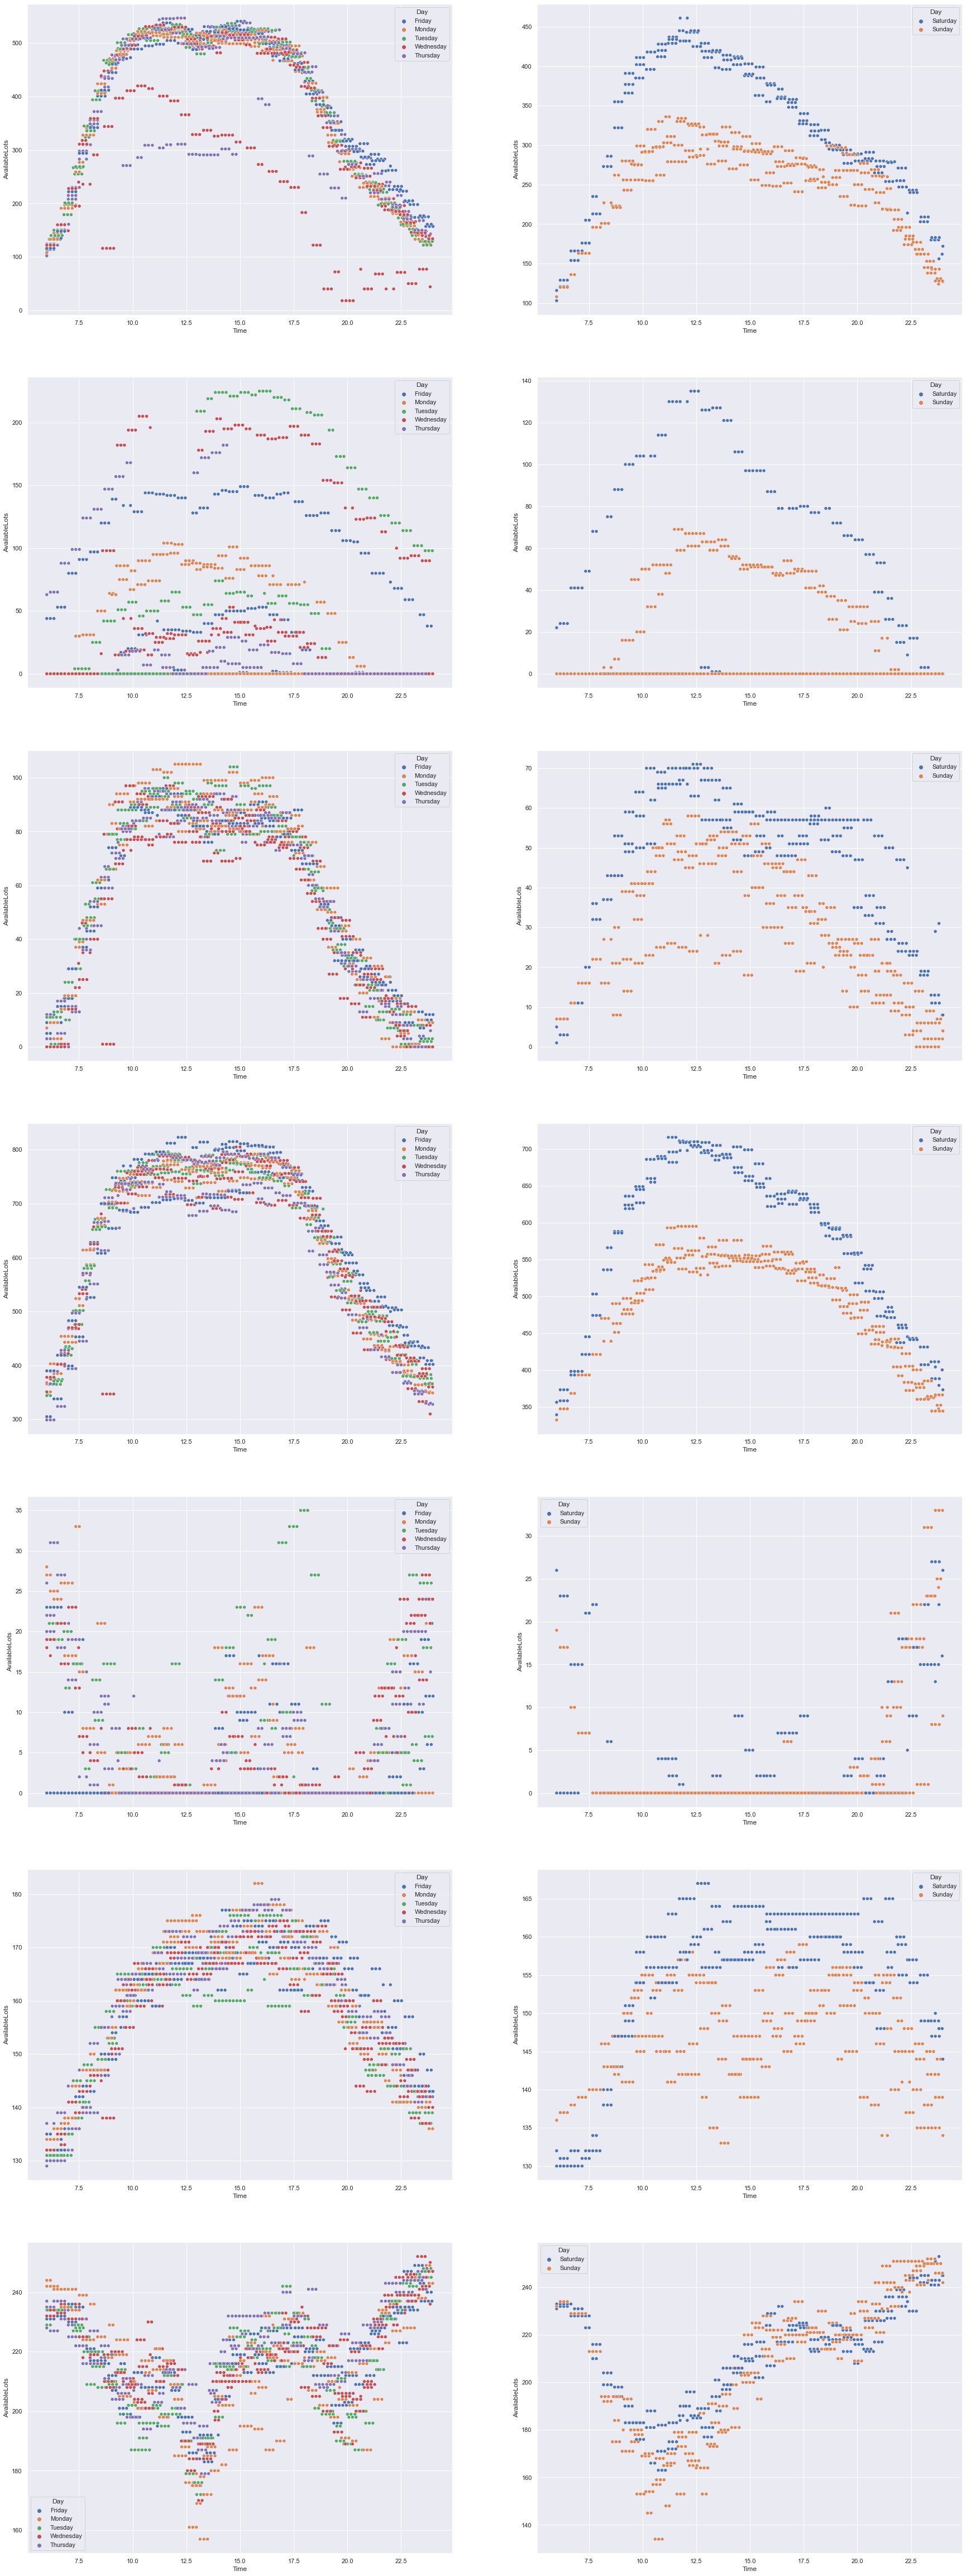

In [20]:
import pandas as pd

#For API request and file/data manipulation
import requests
import json
from datetime import datetime
import os

#GSheets Stuff
import gspread
from df2gspread import df2gspread as d2g
from df2gspread import gspread2df as g2d
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient import discovery

#For Sleep
import time

#For Geocoding
from geopy.geocoders import Nominatim
import geocoder

#For Graphing
import seaborn as sb
import matplotlib.pyplot as plt 
import numpy as np
sb.set()

#Linreg
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
    
coordinates = get_search_location()
df1 = getData(coordinates, "16/4/2021", False)
df2 = getData(coordinates, "18/4/2021", False)

CarParkID1 = df1["CarParkID"].unique()
f, axes = plt.subplots(len(CarParkID1), 2, figsize=(30,12*len(CarParkID1)))
legend_map = {'0': 'Monday',
              '1': 'Tuesday',
              '2': 'Wednesday',
              '3': 'Thursday',
              '4': 'Friday',
              '5': 'Saturday',
              '6': 'Sunday'}

counter = 0
for ID in CarParkID1:
    lotinfo = df1[df1["CarParkID"] == ID]
    lotinfo = lotinfo.sort_values(by=['Date'])
    lotinfo = lotinfo.reset_index(drop=True)
    sb.scatterplot(x=lotinfo["Time"]/60, y=lotinfo["AvailableLots"], hue=lotinfo['Day'].map(legend_map), ax=axes[counter, 0])
    counter += 1
    
CarParkID2 = df2["CarParkID"].unique()

counter = 0
for ID in CarParkID2:
    lotinfo = df2[df2["CarParkID"] == ID]
    lotinfo = lotinfo.sort_values(by=['Date'])
    lotinfo = lotinfo.reset_index(drop=True)
    sb.scatterplot(x=lotinfo["Time"]/60, y=lotinfo["AvailableLots"], hue=lotinfo['Day'].map(legend_map), ax=axes[counter, 1])
    counter += 1

In [16]:
#df is a dataframe containing all data of all carparks to be predicted
#predhr is an int of hour in 24h format
def makePrediction(df, predhr):
    print("It is predicted that there are:")
    
    CarParkID = df["CarParkID"].unique()
    f, axes = plt.subplots(len(CarParkID), 2, figsize=(30,12*len(CarParkID)))
    legend_map = {'0': 'Monday',
                  '1': 'Tuesday',
                  '2': 'Wednesday',
                  '3': 'Thursday',
                  '4': 'Friday'}

    counter = 0
    for ID in CarParkID:
        counter += 1
        lotinfo = df[df["CarParkID"] == ID]
        lotinfo = lotinfo.sort_values(by=['Date'])
        lotinfo = lotinfo.reset_index(drop=True)
        
        dates = lotinfo["Date"].unique()
        test_data_portion = len(dates) // 4

        train_data = pd.DataFrame()
        test_data = pd.DataFrame()

        for i in dates[:-test_data_portion]:
            train_data = train_data.append(lotinfo[lotinfo["Date"] == i])
        for i in dates[-test_data_portion:]:
            test_data = test_data.append(lotinfo[lotinfo["Date"] ==i])

        train_x = pd.DataFrame(train_data['Time'])
        train_y = pd.DataFrame(train_data['AvailableLots'])
        test_x = pd.DataFrame(test_data['Time'])
        test_y = pd.DataFrame(test_data['AvailableLots'])

        max_degree = 10
        best_degree = 1
        r2_train = 0
        for degree in range(1, max_degree+1):
            model = fitModel(degree, train_x, train_y)
            train_y_poly_pred = model.predict(polynomialTransform(degree, train_x))

            r2 = r2_score(train_y, train_y_poly_pred)
            if r2 > r2_train:
                r2_train = r2
                best_degree = degree
        
        model = fitModel(best_degree, train_x, train_y)
        train_y_poly_pred = model.predict(polynomialTransform(best_degree, train_x))
        axes[counter-1, 0].scatter(train_data["Time"]/60, train_data["AvailableLots"])
        sb.scatterplot(x=train_data["Time"]/60, y=train_data["AvailableLots"], hue=train_data['Day'].map(legend_map), ax=axes[counter-1, 0])
        sb.lineplot(x=train_data["Time"]/60, y=pd.DataFrame(train_y_poly_pred)[0], ax=axes[counter-1, 0], linewidth = 5)
        
        #Calculate test r2 score
        test_y_poly_pred = model.predict(polynomialTransform(best_degree, test_x))
        r2_test = r2_score(test_y, test_y_poly_pred)
        #sb.scatterplot(x=test_data["Time"]/60, y=test_data["AvailableLots"], hue=test_data['Day'].map(legend_map), ax=axes[counter-1, 1])
        #sb.lineplot(x=test_data["Time"]/60, y=pd.DataFrame(test_y_poly_pred)[0], ax=axes[counter-1, 1], linewidth = 5)
        
        #barplot
        rows=[]
        for a in range(6, 25):
            predtime = [[a*60]]
            pred = pd.DataFrame(predtime, columns = ['Time'])
            slots = round(model.predict(polynomialTransform(best_degree, pred))[0][0])
            if slots < 0:
                slots = 0
            rows.append([a,slots])
        carparkslots=pd.DataFrame(rows, columns = ['Time','Predicted carpark slots'])
        carparkslots.plot.bar(x="Time", y="Predicted carpark slots", rot=0, ax=axes[counter-1, 1])
        
        #predict
        predtime = [[predhr*60]]
        pred = pd.DataFrame(predtime, columns = ['Time'])
        slots = round(model.predict(polynomialTransform(best_degree, pred))[0][0])
        if slots < 0:
            slots = 0
        
        development = lotinfo["Development"][0]
        rates = getRates(lotinfo["Agency"][0], ID)
        
        print(str(counter)+ ". " + str(slots) + " carpark slots in " + development +" at "+ str(predhr) +" 00 HRS. Rates: " + rates + " per half an hr")
        print("Best degree:", best_degree)
        print("Degree of fitness to train data:", r2_train)
        print("Degree of fitness to test data:", r2_test)
        print()
        
def fitModel(degree, x, y):
    x_poly = polynomialTransform(degree, x)
    linreg = LinearRegression()
    linreg.fit(x_poly, y)
    return linreg

def polynomialTransform(degree, x):
    poly_reg = PolynomialFeatures(degree=degree)
    x_poly = poly_reg.fit_transform(x)
    return x_poly

In [6]:
def getRates(agency, ID):
    if agency == "HDB":
        within_central_area = ["ACB", "BBB", "BRB1", "CY", "DUXM", "HLM", "KAB", "KAM", "KAS", "PRM", "SLS", "SR1", "SR2", "TPM", "UCS", "WCB"]
        if (ID in within_central_area) and predDay == 6 and (int(datetime.strftime(predhr, '%H')) > 17):
            rates = "$1.20"
        else:
            rates = "$0.60"
    elif agency == "LTA":
        rates = "Meme"
        # URA
    else:
        URAdf = pd.read_csv("./URA.csv")
        if (datetime.strptime(predDate, '%d/%m/%Y').weekday() < 6):
            rates = URAdf.loc[URAdf['ppCode']==ID]["weekdayRate"].values[0]
        else:
            rates = URAdf.loc[URAdf['ppCode']==ID]["sunPHRate"].values[0]
    return rates

Please enter a location: ntu

Do you mean?
1. Nanyang Technological University, Nanyang Crescent, Western Water Catchment, Southwest, 637122, Singapore
2. Try again
Your choice: 1

It is predicted that there are:
1. 486 carpark slots in BLK 912/932 JURONG WEST STREET 92 at 15 00 HRS. Rates: $0.60 per half an hr
Best degree: 6
Degree of fitness to train data: 0.7896095345282987
Degree of fitness to test data: 0.9393612568013427

2. 49 carpark slots in BLK 902/908 JURONG WEST STREET 91 at 15 00 HRS. Rates: $0.60 per half an hr
Best degree: 5
Degree of fitness to train data: 0.07121897479595729
Degree of fitness to test data: -2.610716968928212

3. 87 carpark slots in BLK 909/911 JURONG WEST STREET 91 at 15 00 HRS. Rates: $0.60 per half an hr
Best degree: 6
Degree of fitness to train data: 0.9301961887158844
Degree of fitness to test data: 0.9374093701321271

4. 758 carpark slots in BLK 933-953 JURONG WEST STREET 91 at 15 00 HRS. Rates: $0.60 per half an hr
Best degree: 6
Degree of fitnes

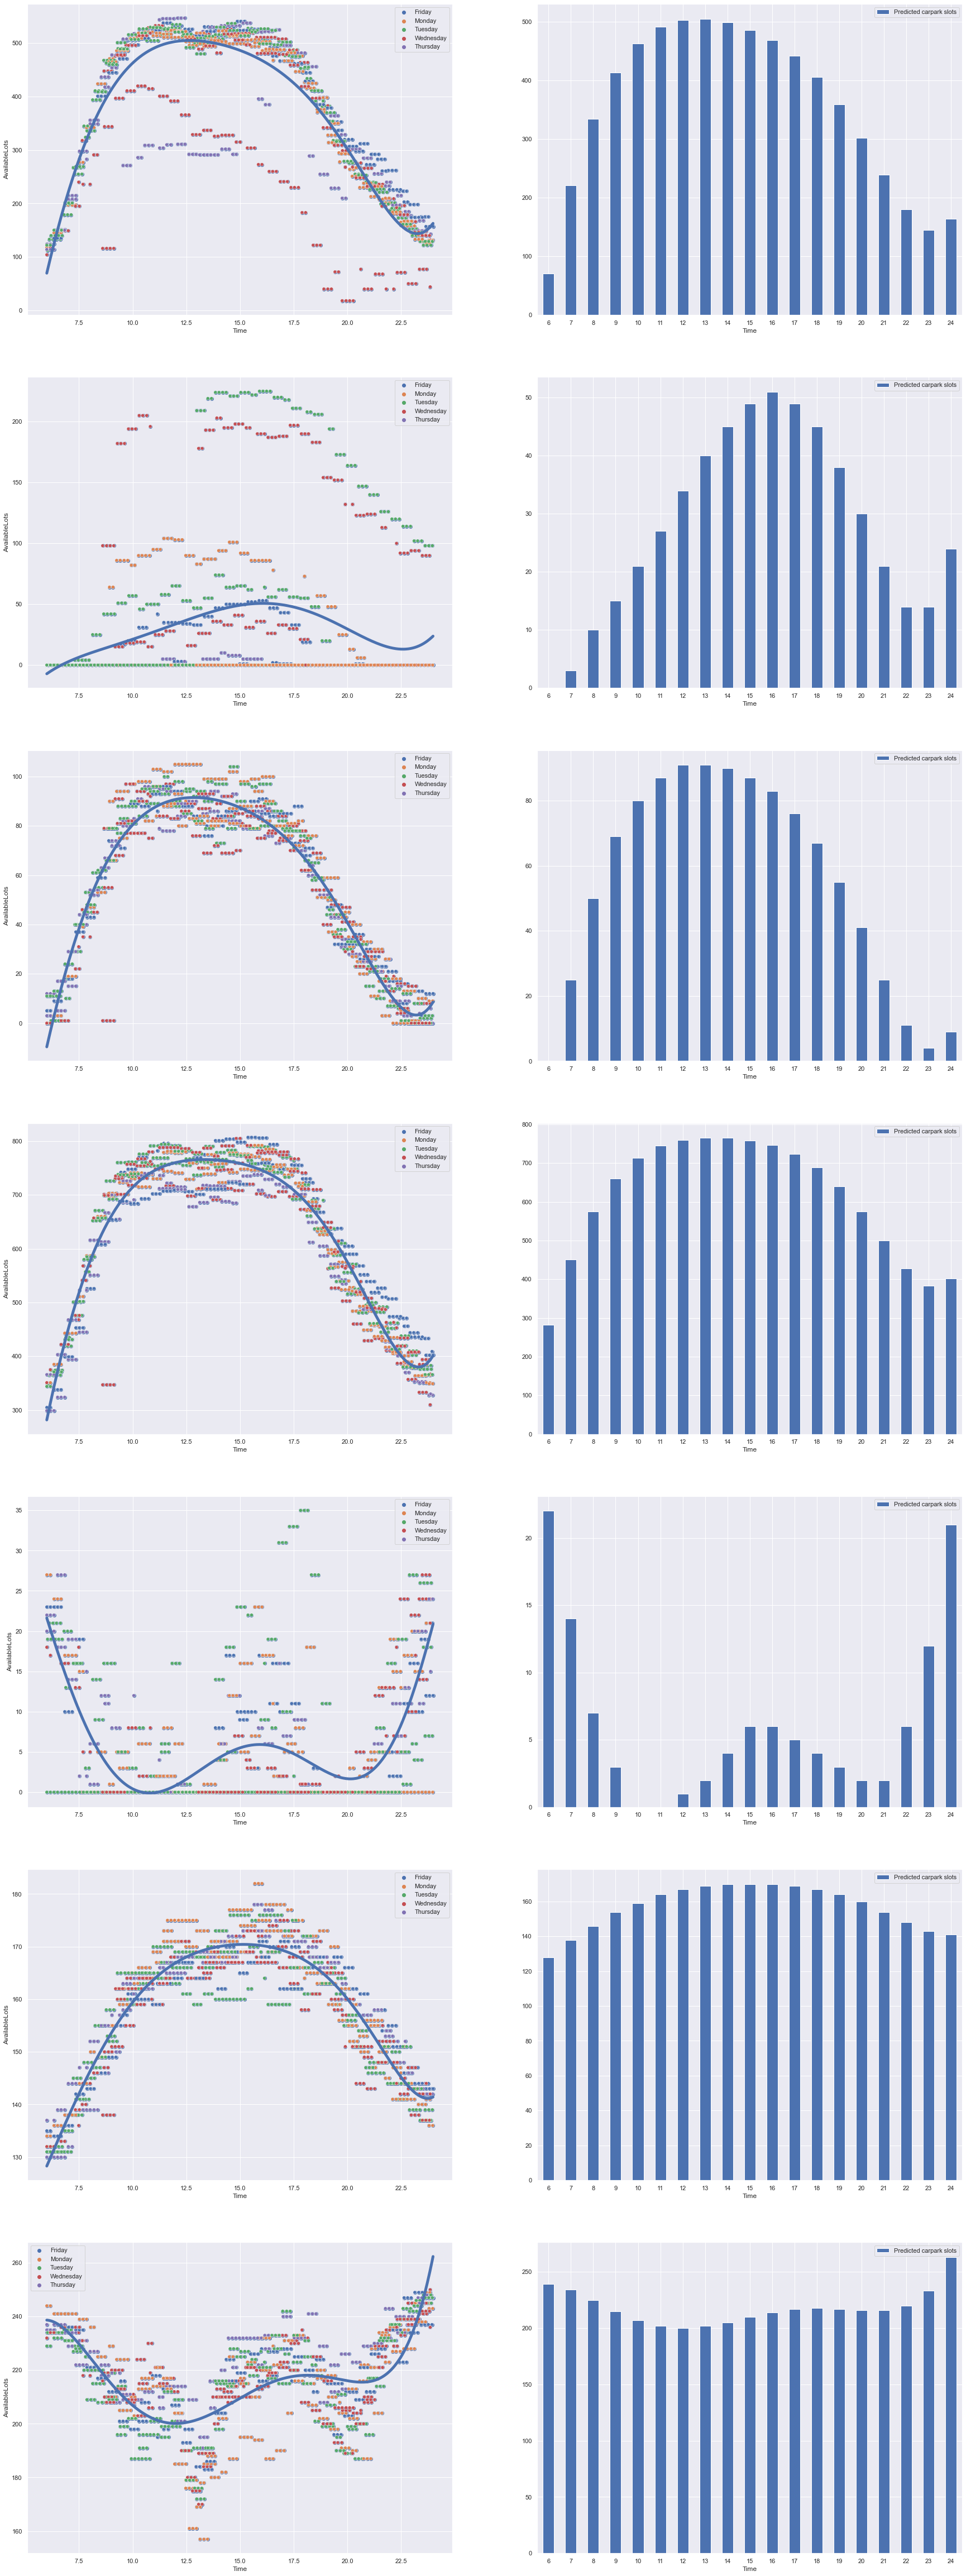

In [7]:
import pandas as pd

#For API request and file/data manipulation
import requests
import json
from datetime import datetime
import os

#GSheets Stuff
import gspread
from df2gspread import df2gspread as d2g
from df2gspread import gspread2df as g2d
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient import discovery

#For Sleep
import time

#For Geocoding
from geopy.geocoders import Nominatim
import geocoder

#For Graphing
import seaborn as sb
import matplotlib.pyplot as plt 
import numpy as np
sb.set()

#Linreg
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
    
coordinates = get_search_location()
df = getData(coordinates, "16/4/2021", False)
makePrediction(df, 15)

In [8]:
def main():
    import pandas as pd

    #For API request and file/data manipulation
    import requests
    import json
    from datetime import datetime
    import os

    #GSheets Stuff
    import gspread
    from df2gspread import df2gspread as d2g
    from df2gspread import gspread2df as g2d
    from oauth2client.service_account import ServiceAccountCredentials
    from googleapiclient import discovery

    #For Sleep
    import time

    #For Geocoding
    from geopy.geocoders import Nominatim
    import geocoder

    #For Graphing
    import seaborn as sb
    import matplotlib.pyplot as plt 
    import numpy as np
    sb.set()

    #Linreg
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.metrics import mean_squared_error, r2_score
    
    mainpage = '''Options:
    1. Upload today's data
    2. Update to latest data
    3. Search'''
    print(mainpage)

    while True:
        try:
            action = int(input())
            if action < 1 or action > 3:
                print("Invalid input!")
            else:
                break
        except:
            print("Invalid input!")
            
    if action == 1:
        upload_to_sheets()
        
    elif action == 2:
        download_from_google_sheets()
        
    elif action == 3:
        coordinates = get_search_location()
        date = input("Enter the date in d/m/yyyy format: ")
        while True:
            try:
                hour = int(input("Enter the hour in 24h format (0 ~ 23): "))
                if hour < 0 or hour > 23:
                    print("Invalid input!")
                else:
                    break
            except:
                print("Invalid input!")
        df = getData(coordinates, date, False)
        makePrediction(df, hour)

In [9]:
main()

Options:
    1. Upload today's data
    2. Update to latest data
    3. Search
2
3_4_2021_carpark_availability.csv downloaded
14_4_2021_carpark_availability.csv downloaded
15_4_2021_carpark_availability.csv downloaded


Options:
    1. Upload today's data
    2. Update to latest data
    3. Search
3
Please enter a location: marina

Do you mean?
1. Marina Bay Sands, 10, Bayfront Avenue, Bayfront, Downtown Core, Singapore, Central, 018956, Singapore
2. Marina Bay, Bayfront Avenue, Downtown Central, Downtown Core, Singapore, Central, 18990, Singapore
3. Marina Bay, Downtown Core, Singapore, Central, 018935, Singapore
4. Marina South Pier, Marina Coastal Expressway, Marina South, Singapore, Central, 018988, Singapore
5. Marina Bay Financial Centre Tower 2, 10, Marina Boulevard, Downtown Central, Downtown Core, Singapore, Central, 018983, Singapore
6. The Sail @ Marina Bay, Downtown Core, Singapore, Central, 018987, Singapore
7. Marina Barrage, Marina South, Singapore, Central, Singapore
8. Marina Square, 6, Raffles Boulevard, Downtown Core, Singapore, Central, 039594, Singapore
9. NTUC Centre, 1, Marina Boulevard, Downtown Central, Downtown Core, Singapore, Central, 018989, Singapore
10. Marina South, Sin

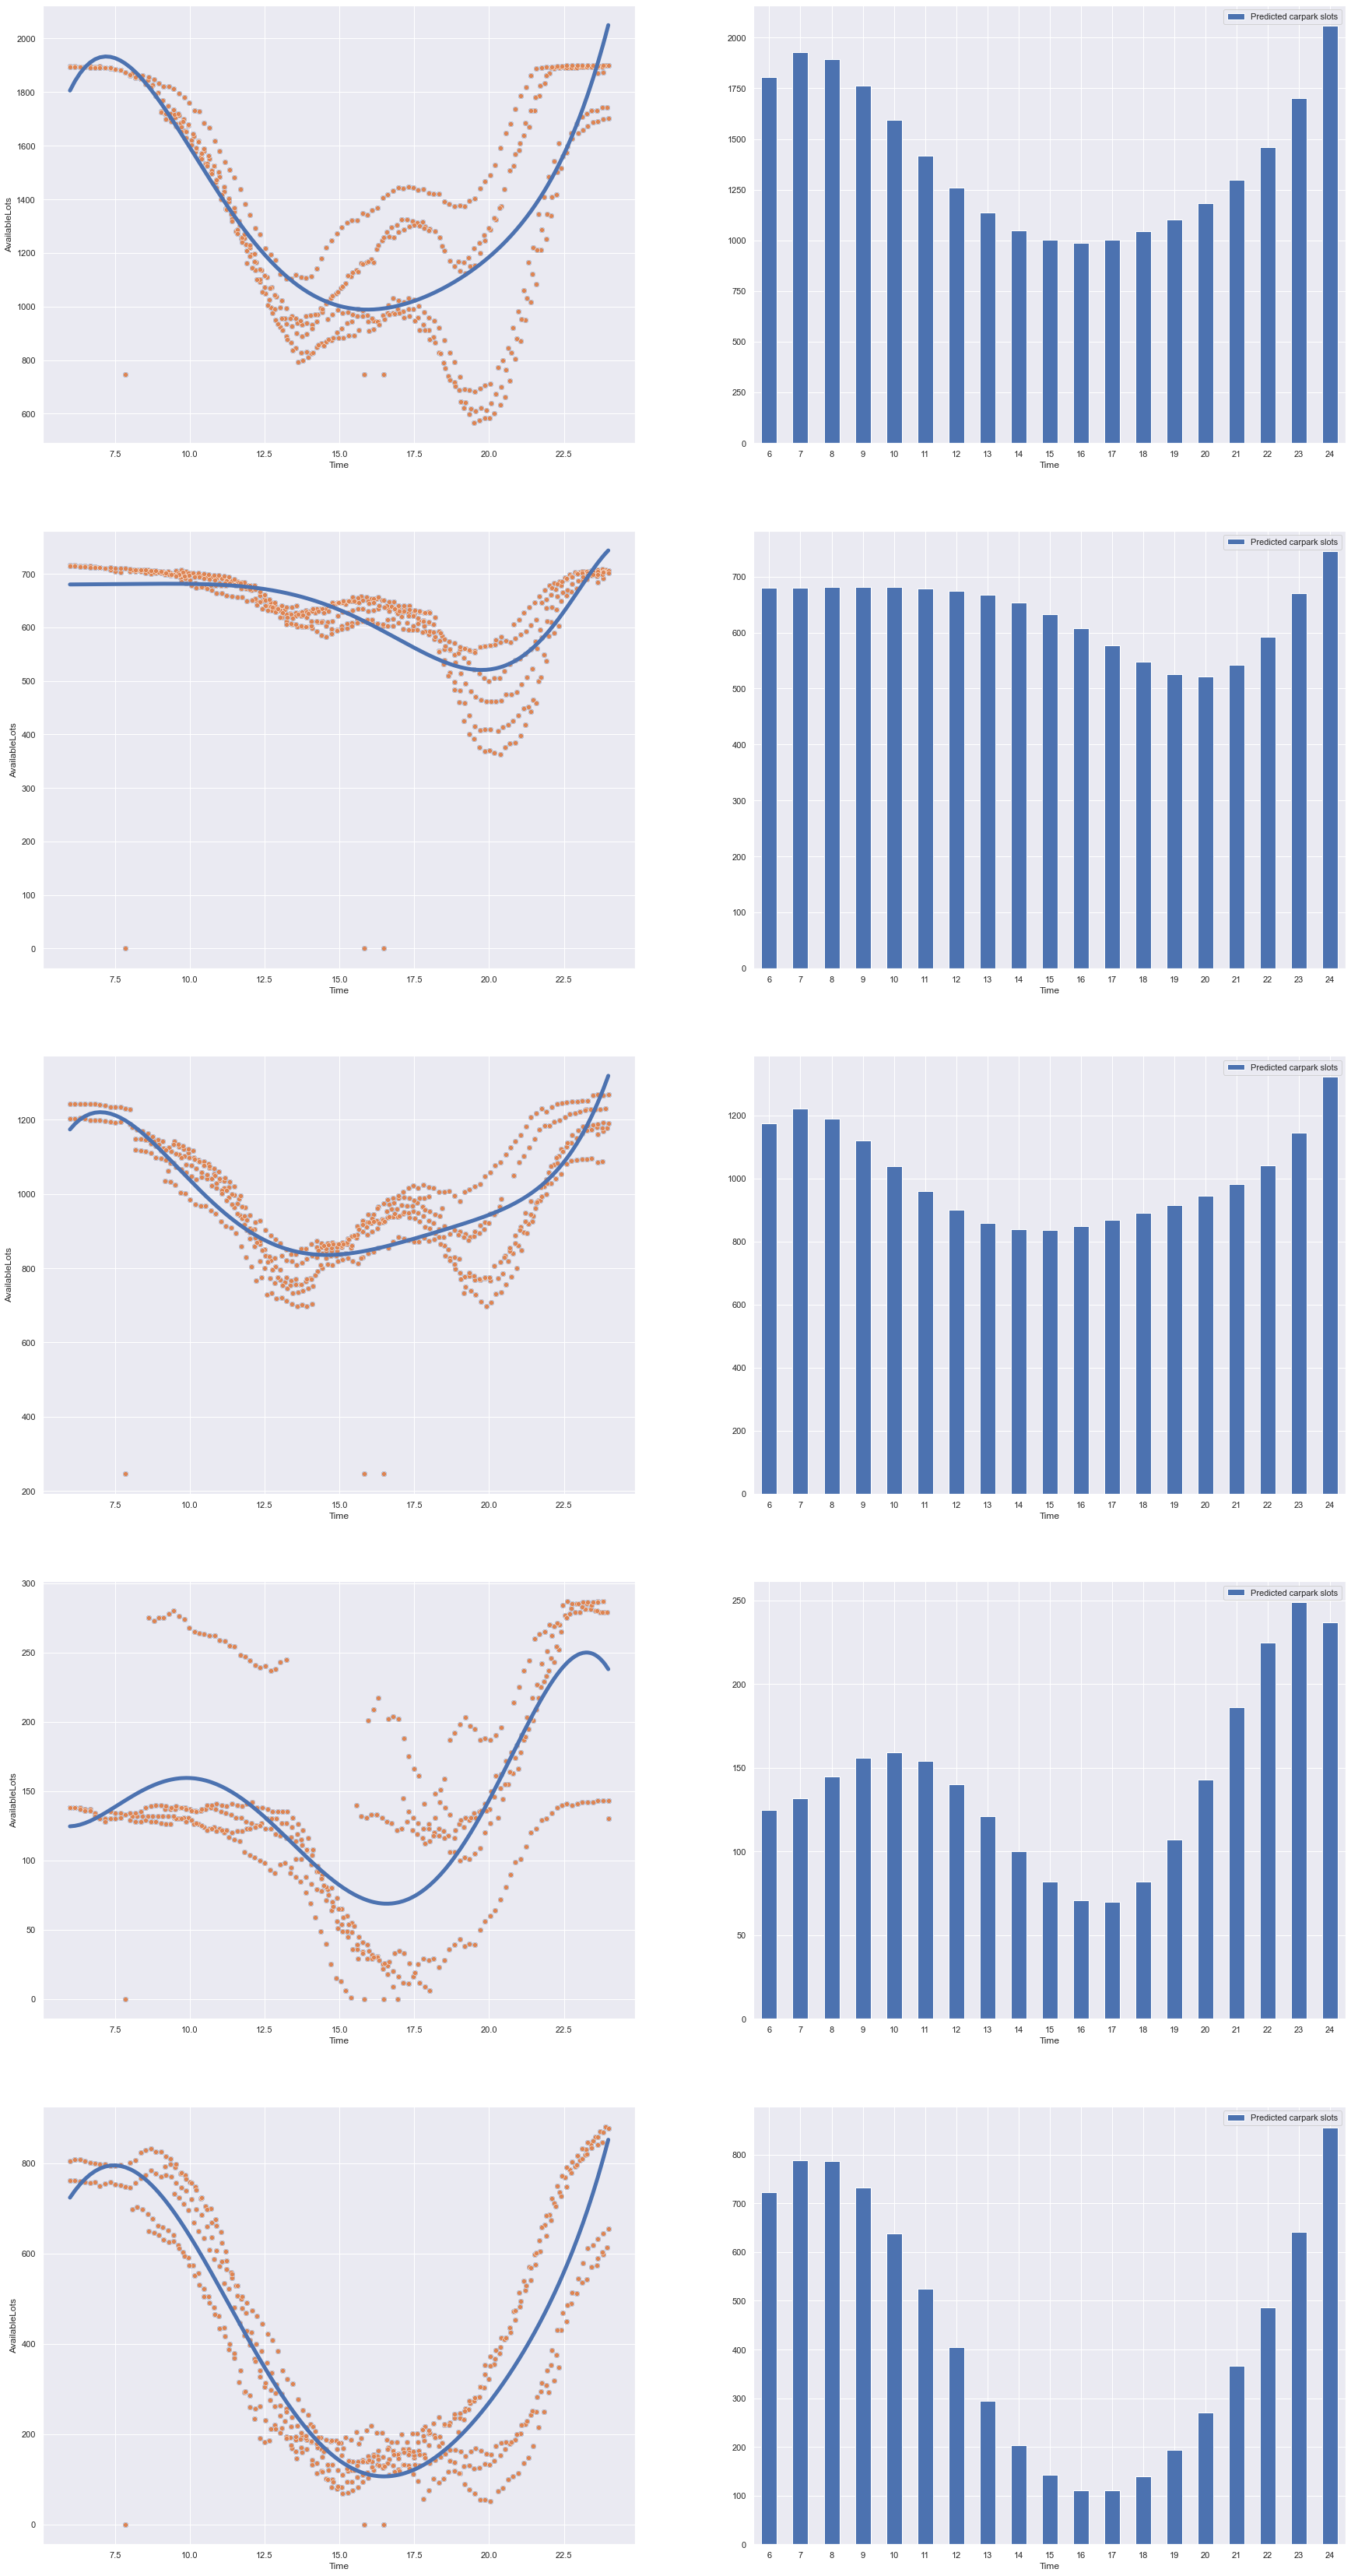

In [13]:
main()